# ЧАСТИНА 1: Підготовка до виконання проекту

In [1]:
import zipfile

with zipfile.ZipFile('Animals-10.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/animals10')

### 1. Перевірка структури та підготовка середовища

In [2]:
import os
from pathlib import Path

dataset_path = Path('/content/animals10/raw-img')

# Dictionary for class translation: Italian → English
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}

classes = sorted([folder.name for folder in dataset_path.iterdir() if folder.is_dir()])
translated_classes = [translate[cls] for cls in classes]
print("Classes:", translated_classes)

Classes: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


### 2. Підрахунок зображень у кожному класі

In [3]:
for cls in classes:
    img_count = len(list((dataset_path / cls).glob('*')))
    print(f"{translate[cls]}: {img_count} images")

dog: 4863 images
horse: 2623 images
elephant: 1446 images
butterfly: 2112 images
chicken: 3098 images
cat: 1668 images
cow: 1866 images
sheep: 1820 images
spider: 4821 images
squirrel: 1862 images


### 3. Розділення на train / val / test

In [4]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import shutil

def prepare_splits(base_dir, output_dir, val_ratio=0.15, test_ratio=0.15):
    base_dir = Path(base_dir)
    output_dir = Path(output_dir)

    # Create output folders with translated names
    for split in ['train', 'val', 'test']:
        for it_name, en_name in translate.items():
            (output_dir / split / en_name).mkdir(parents=True, exist_ok=True)

    # Process each Italian class
    for it_name, en_name in translate.items():
        source_folder = base_dir / it_name
        if not source_folder.exists():
            print(f"Source folder not found for class '{it_name}'")
            continue

        images = list(source_folder.glob('*'))

        if len(images) == 0:
            print(f"No images found for class '{it_name}'")
            continue

        # Step 3: Split into train, val, test
        train_imgs, temp_imgs = train_test_split(
            images, test_size=val_ratio + test_ratio, random_state=42
        )
        val_imgs, test_imgs = train_test_split(
            temp_imgs, test_size=test_ratio / (val_ratio + test_ratio), random_state=42
        )

        # Step 4: Copy images to destination folders (translated names)
        for img in train_imgs:
            shutil.copy(img, output_dir / 'train' / en_name / img.name)
        for img in val_imgs:
            shutil.copy(img, output_dir / 'val' / en_name / img.name)
        for img in test_imgs:
            shutil.copy(img, output_dir / 'test' / en_name / img.name)

        print(f"Processed '{it_name}' → '{en_name}': "
              f"{len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")

    print("Dataset successfully split and translated.")

prepare_splits('/content/animals10/raw-img', '/content/dataset_split')


Processed 'cane' → 'dog': 3404 train, 729 val, 730 test
Processed 'cavallo' → 'horse': 1836 train, 393 val, 394 test
Processed 'elefante' → 'elephant': 1012 train, 217 val, 217 test
Processed 'farfalla' → 'butterfly': 1478 train, 317 val, 317 test
Processed 'gallina' → 'chicken': 2168 train, 465 val, 465 test
Processed 'gatto' → 'cat': 1167 train, 250 val, 251 test
Processed 'mucca' → 'cow': 1306 train, 280 val, 280 test
Processed 'pecora' → 'sheep': 1274 train, 273 val, 273 test
Processed 'ragno' → 'spider': 3374 train, 723 val, 724 test
Processed 'scoiattolo' → 'squirrel': 1303 train, 279 val, 280 test
Dataset successfully split and translated.


### 4. Формат файлів

In [5]:
import PIL

example = list((dataset_path / classes[0]).glob('*'))[0]
img = PIL.Image.open(example)
print("Size:", img.size)
print("Format:", img.format)
img.show()

Size: (300, 180)
Format: JPEG


### 5. Перетворення зображень у тензори + аугментація

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformation pipeline for training set with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),             # Resize all images to 128x128
    transforms.RandomHorizontalFlip(),         # Randomly flip images horizontally
    transforms.RandomRotation(10),             # Random rotation up to ±10 degrees
    transforms.ToTensor(),                     # Convert PIL Image to PyTorch tensor
    transforms.Normalize([0.5], [0.5])          # Normalize pixel values to range [-1, 1]
])

# Define transformation pipeline for validation and test sets (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),             # Resize images
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize([0.5], [0.5])          # Normalize
])

# Load the datasets using ImageFolder
train_dataset = ImageFolder('/content/dataset_split/train', transform=transform_train)
val_dataset = ImageFolder('/content/dataset_split/val', transform=transform_test)
test_dataset = ImageFolder('/content/dataset_split/test', transform=transform_test)


### 6. DataLoader

In [7]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


### 7. Візуалізація зображень з класами

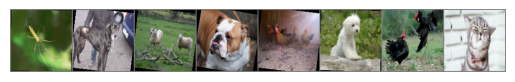

Labels: ['spider', 'dog', 'sheep', 'dog', 'chicken', 'dog', 'chicken', 'cat']


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to denormalize and display a batch of images
def imshow(img):
    img = img / 2 + 0.5            # Denormalize (reverse normalization)
    npimg = img.numpy()           # Convert tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Change channel order for display
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first 8 images from the batch
imshow(torchvision.utils.make_grid(images[:8]))

print('Labels:', [train_dataset.classes[label] for label in labels[:8]])


### 8. Гістограма розподілу класів

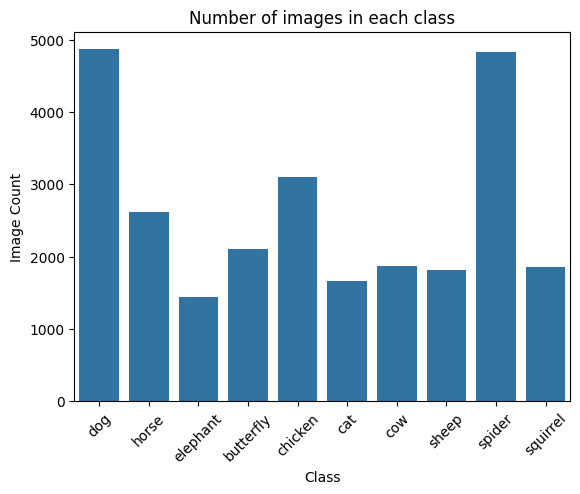

In [9]:
import seaborn as sns
import pandas as pd

# List to store image counts per class
counts = []

for cls in classes:
    num = len(list((dataset_path / cls).glob('*')))
    translated_name = translate[cls]  # Translate class name to English
    counts.append({'class': translated_name, 'count': num})

# Create DataFrame for plotting
df = pd.DataFrame(counts)

# Plot class distribution as a bar chart
sns.barplot(data=df, x='class', y='count')
plt.xticks(rotation=45)
plt.title("Number of images in each class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.show()


### Планування наступного етапу:

**Метрики ефективності моделі:**

*   Accuracy — частка правильних передбачень;
*   Precision — точність передбачень для кожного класу;
*   Recall — повнота виявлення правильних об’єктів;
*   F1-score — баланс між precision і recall;
*   Confusion matrix — покаже, що з чим модель плутає.

**Запланована архітектура нейронної мережі:**

*   Кількість згорткових шарів: 2–3;
*   Кількість фільтрів: 32 → 64 → 128;
*   Активація: ReLU після кожного згорткового шару;
*   Pooling: MaxPooling2D після кожного другого шару;
*   Dropout: 0.3–0.5 для запобігання перенавчанню;
*   Flatten після згорток і pooling;
*   Кількість повнозв’язаних шарів: 1–2 (наприклад: 256 → 10);
*   Фінальна активація: Softmax;
*   Оптимізатор: Adam;
*   Функція втрат: CrossEntropyLoss (багатокласова класифікація).

# ЧАСТИНА 2: Побудова базової моделі нейронної мережі

### 🧩 Реалізація простої архітектури CNN

#### 🧱 Основні компоненти:
- **3 згорткових шари (Conv2D)**:
  - Кожен має ядро 3x3, padding=1 (щоб зберігати розмір зображення).
  - Кількість фільтрів: 32 → 64 → 128.
- **ReLU**: активаційна функція після кожної згортки.
- **MaxPooling2D**: зменшує просторові розміри (після кожного згорткового блоку).
- **Flatten**: перетворює 3D-вихід у вектор для повнозв’язаних шарів.
- **Dense (Linear) шари**:
  - Один прихований шар на 256 нейронів + Dropout(0.5)
  - Вихідний шар на 10 нейронів (за кількістю класів)
- **Softmax не використовується явно**, бо функція втрат `CrossEntropyLoss` включає його автоматично.

Модель легко адаптувати до іншої кількості класів через параметр `num_classes`.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a basic Convolutional Neural Network
class AnimalCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AnimalCNN, self).__init__()

        # 1st Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # padding=1 to preserve size
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size by half

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Input size depends on final feature map
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)  # Output layer: one unit per class

    def forward(self, x):
        # Pass through convolutional layers with ReLU and pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten feature map to feed into fully connected layers
        x = x.view(-1, 128 * 16 * 16)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Final output (no softmax needed if using CrossEntropyLoss)

        return x

# Create model and move to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AnimalCNN(num_classes=10).to(device)

print(model)


AnimalCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


### ⚙️ Налаштування функції втрат і оптимізатора

#### 🧮 Функція втрат:
- Використовується **`CrossEntropyLoss`**, яка підходить для задач **багатокласової класифікації**.
- Вона **автоматично включає softmax**, тому в моделі його можна не використовувати окремо.

#### ⚙️ Оптимізатор:
- Обрано **`Adam`** — сучасний оптимізатор, який адаптує швидкість навчання для кожного параметра.
- Початковий learning rate встановлено на **0.001**.

#### 📉 Зменшення learning rate (scheduler):
- Додатково використовується **`ReduceLROnPlateau`**, який зменшує learning rate, якщо **val_loss не покращується** протягом кількох епох (в даному випадку — 3).
- Це допомагає уникати “застрявання” на плато.


In [11]:
import torch.optim as optim

# Define loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam) with learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Learning rate scheduler to reduce LR on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)


### 🚀 Тренування моделі

#### 🔧 Налаштування:
- **Кількість епох**: 20
- **Batch size**: 32 (встановлюється у DataLoader)
- **Функція втрат**: CrossEntropyLoss
- **Оптимізатор**: Adam (lr=0.001)
- **Валідаційна вибірка**: використовується для оцінки якості під час навчання

#### 📈 Що буде виведено:
- Графіки зміни **точності** та **втрат** на train/val наборах
- Фінальна збережена модель для подальшого використання


Код тренування моделі

In [12]:
import time
from sklearn.metrics import accuracy_score

num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # Step the scheduler
    scheduler.step(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, "
          f"Time: {time.time() - start_time:.2f}s")


Epoch [1/20], Train Loss: 1.8363, Train Acc: 0.3485, Val Loss: 1.4318, Val Acc: 0.5010, Time: 71.37s
Epoch [2/20], Train Loss: 1.4401, Train Acc: 0.5085, Val Loss: 1.2974, Val Acc: 0.5408, Time: 71.01s
Epoch [3/20], Train Loss: 1.2903, Train Acc: 0.5614, Val Loss: 1.1640, Val Acc: 0.6113, Time: 69.51s
Epoch [4/20], Train Loss: 1.1728, Train Acc: 0.5985, Val Loss: 1.0975, Val Acc: 0.6251, Time: 69.70s
Epoch [5/20], Train Loss: 1.0955, Train Acc: 0.6256, Val Loss: 1.0457, Val Acc: 0.6518, Time: 67.54s
Epoch [6/20], Train Loss: 1.0179, Train Acc: 0.6577, Val Loss: 0.9595, Val Acc: 0.6814, Time: 68.73s
Epoch [7/20], Train Loss: 0.9650, Train Acc: 0.6738, Val Loss: 0.9382, Val Acc: 0.6826, Time: 70.56s
Epoch [8/20], Train Loss: 0.9112, Train Acc: 0.6876, Val Loss: 0.9305, Val Acc: 0.6836, Time: 70.70s
Epoch [9/20], Train Loss: 0.8584, Train Acc: 0.7114, Val Loss: 0.9286, Val Acc: 0.6831, Time: 68.30s
Epoch [10/20], Train Loss: 0.8233, Train Acc: 0.7204, Val Loss: 0.8818, Val Acc: 0.7056, Ti

Візуалізація точності та втрат

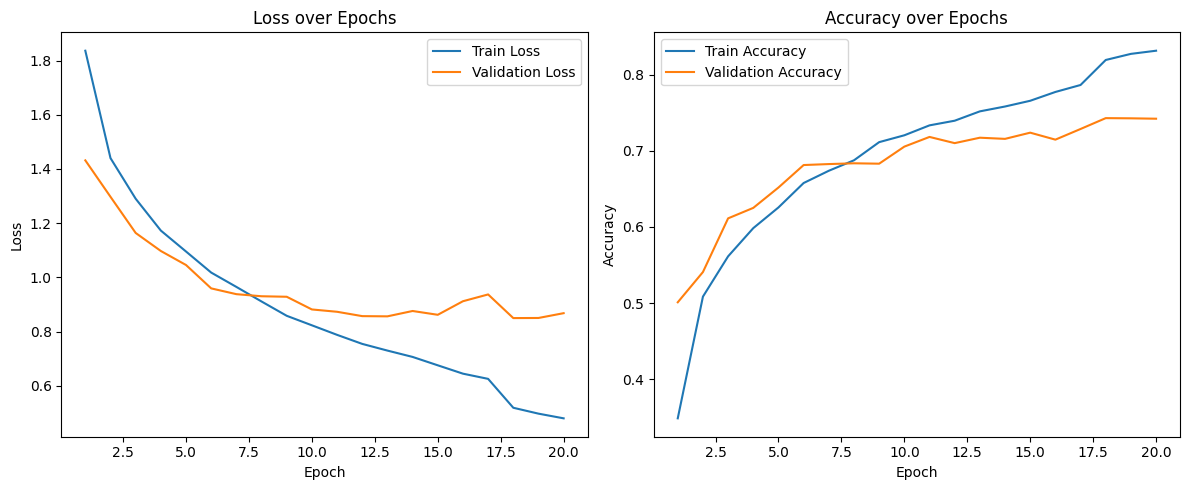

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Збереження моделі

In [14]:
torch.save(model.state_dict(), 'animal_cnn_model.pth')
print("✅ Model saved to animal_cnn_model.pth")

✅ Model saved to animal_cnn_model.pth


# ЧАСТИНА 3: Оптимізація гіперпараметрів моделі нейронної мережі

## 🧪 Ручна оптимізація гіперпараметрів

### 🔧 Варіанти для тестування:

- **Learning Rate**: 0.01, 0.001, 0.0001  
- **Dropout Rate**: 0.3, 0.5, 0.7  
- **FC (Dense) Units**: 128, 256  
- **Conv Layers**: 2 або 3 згорткових шари

Модель буде тренуватись для кожної конфігурації, і ми порівняємо їх результати по точності та втратам.


In [18]:
# Function that builds a CNN model with flexible hyperparameters
class CustomCNN(nn.Module):
    def __init__(self, num_conv_layers=3, fc_units=256, dropout_rate=0.5):
        super(CustomCNN, self).__init__()

        layers = []
        in_channels = 3
        channels = [32, 64, 128][:num_conv_layers]

        for out_channels in channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)

        # Dummy input to calculate output size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)
            conv_output = self.conv(dummy_input)
            self.flat_size = conv_output.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flat_size, fc_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc_units, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


In [19]:
def train_and_evaluate(model, optimizer, criterion, num_epochs=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accuracies,
        "val_acc": val_accuracies
    }


### 🧪 Пошук найкращої конфігурації


In [20]:
import itertools
import pandas as pd
from IPython.display import display

# Define search space for hyperparameters
learning_rates = [0.01, 0.001, 0.0001]
dropouts = [0.3, 0.5]
fc_units_list = [128, 256]
conv_layers_list = [2, 3]

# Store results here
results = []

# Loop through all combinations of hyperparameters
for lr, dr, fc, conv in itertools.product(learning_rates, dropouts, fc_units_list, conv_layers_list):
    print(f"\n🔧 Training: LR={lr}, Dropout={dr}, FC={fc}, Conv={conv}")

    model = CustomCNN(num_conv_layers=conv, fc_units=fc, dropout_rate=dr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    metrics = train_and_evaluate(model, optimizer, criterion, num_epochs=5)

    val_acc_last = metrics["val_acc"][-1]  # take last epoch val accuracy
    results.append({
        "learning_rate": lr,
        "dropout": dr,
        "fc_units": fc,
        "conv_layers": conv,
        "val_accuracy": val_acc_last
    })

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Sort by best validation accuracy
results_df = results_df.sort_values(by="val_accuracy", ascending=False)

display(name="Hyperparameter Results", dataframe=results_df)

# Show best result
best_config = results_df.iloc[0]
print("\n🏆 Best configuration:")
print(best_config)



🔧 Training: LR=0.01, Dropout=0.3, FC=128, Conv=2
Epoch [1/5] - Train Loss: 2.5262, Train Acc: 0.1839, Val Loss: 2.2079, Val Acc: 0.1857
Epoch [2/5] - Train Loss: 2.2091, Train Acc: 0.1868, Val Loss: 2.2086, Val Acc: 0.1842
Epoch [3/5] - Train Loss: 2.2089, Train Acc: 0.1835, Val Loss: 2.2077, Val Acc: 0.1842
Epoch [4/5] - Train Loss: 2.2088, Train Acc: 0.1827, Val Loss: 2.2090, Val Acc: 0.1842
Epoch [5/5] - Train Loss: 2.2087, Train Acc: 0.1813, Val Loss: 2.2093, Val Acc: 0.1857

🔧 Training: LR=0.01, Dropout=0.3, FC=128, Conv=3
Epoch [1/5] - Train Loss: 2.4557, Train Acc: 0.1812, Val Loss: 2.2102, Val Acc: 0.1857
Epoch [2/5] - Train Loss: 2.2103, Train Acc: 0.1827, Val Loss: 2.2099, Val Acc: 0.1857
Epoch [3/5] - Train Loss: 2.2096, Train Acc: 0.1844, Val Loss: 2.2082, Val Acc: 0.1842
Epoch [4/5] - Train Loss: 2.2086, Train Acc: 0.1888, Val Loss: 2.2088, Val Acc: 0.1857
Epoch [5/5] - Train Loss: 2.2092, Train Acc: 0.1824, Val Loss: 2.2081, Val Acc: 0.1857

🔧 Training: LR=0.01, Dropout=

## 🤖 Автоматизована оптимізація гіперпараметрів (Optuna)

У цьому розділі використовується бібліотека **Optuna** для автоматизованого підбору гіперпараметрів моделі.

### Що буде тюнитись:
- Learning rate
- Dropout rate
- Кількість фільтрів (нейронів) у повнозв’язаному шарі
- Кількість згорткових шарів

Кожна конфігурація буде оцінюватись за валідаційною точністю (validation accuracy).


In [21]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00


In [22]:
import optuna
from optuna.trial import Trial
from optuna.samplers import TPESampler

def objective(trial: Trial):
    # Sample hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    dropout = trial.suggest_float('dropout', 0.3, 0.7)
    fc_units = trial.suggest_categorical('fc_units', [128, 256])
    conv_layers = trial.suggest_int('conv_layers', 2, 3)

    # Build model with sampled hyperparameters
    model = CustomCNN(
        num_conv_layers=conv_layers,
        fc_units=fc_units,
        dropout_rate=dropout
    ).to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate the model
    metrics = train_and_evaluate(model, optimizer, criterion, num_epochs=5)

    # Return final validation accuracy (last epoch)
    final_val_acc = metrics["val_acc"][-1]
    return final_val_acc

# Create a study to maximize validation accuracy
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=10)  # Run 10 different trials

# Print best result
print("\n🏆 Best configuration found:")
print(study.best_params)
print(f"📈 Best validation accuracy: {study.best_value:.4f}")


[I 2025-04-07 19:01:47,579] A new study created in memory with name: no-name-6f3f12ba-f7af-4c1d-ba9f-2fc2896fac07
<ipython-input-22-78e6341fbe8e>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)


Epoch [1/5] - Train Loss: 1.8460, Train Acc: 0.3487, Val Loss: 1.4526, Val Acc: 0.4969
Epoch [2/5] - Train Loss: 1.4376, Train Acc: 0.5064, Val Loss: 1.2440, Val Acc: 0.5828
Epoch [3/5] - Train Loss: 1.2478, Train Acc: 0.5680, Val Loss: 1.1140, Val Acc: 0.6210
Epoch [4/5] - Train Loss: 1.1494, Train Acc: 0.6062, Val Loss: 1.0606, Val Acc: 0.6396


[I 2025-04-07 19:07:45,942] Trial 0 finished with value: 0.6609780947529292 and parameters: {'lr': 0.001017889042427717, 'dropout': 0.43857895564024546, 'fc_units': 256, 'conv_layers': 3}. Best is trial 0 with value: 0.6609780947529292.


Epoch [5/5] - Train Loss: 1.0615, Train Acc: 0.6313, Val Loss: 1.0179, Val Acc: 0.6610
Epoch [1/5] - Train Loss: 2.3231, Train Acc: 0.1802, Val Loss: 2.2089, Val Acc: 0.1857
Epoch [2/5] - Train Loss: 2.2093, Train Acc: 0.1866, Val Loss: 2.2082, Val Acc: 0.1857
Epoch [3/5] - Train Loss: 2.2084, Train Acc: 0.1858, Val Loss: 2.2089, Val Acc: 0.1842
Epoch [4/5] - Train Loss: 2.2087, Train Acc: 0.1848, Val Loss: 2.2079, Val Acc: 0.1857


[I 2025-04-07 19:13:54,644] Trial 1 finished with value: 0.18568517575140092 and parameters: {'lr': 0.006967084284213658, 'dropout': 0.6645993079773237, 'fc_units': 256, 'conv_layers': 3}. Best is trial 0 with value: 0.6609780947529292.


Epoch [5/5] - Train Loss: 2.2085, Train Acc: 0.1840, Val Loss: 2.2077, Val Acc: 0.1857
Epoch [1/5] - Train Loss: 2.1066, Train Acc: 0.2583, Val Loss: 1.9609, Val Acc: 0.3069
Epoch [2/5] - Train Loss: 1.9622, Train Acc: 0.3029, Val Loss: 1.9301, Val Acc: 0.3271
Epoch [3/5] - Train Loss: 1.9018, Train Acc: 0.3211, Val Loss: 1.8110, Val Acc: 0.3721
Epoch [4/5] - Train Loss: 1.8653, Train Acc: 0.3375, Val Loss: 1.7953, Val Acc: 0.3770


[I 2025-04-07 19:19:20,352] Trial 2 finished with value: 0.37264391237901173 and parameters: {'lr': 0.002289865024499674, 'dropout': 0.6066612794359478, 'fc_units': 128, 'conv_layers': 2}. Best is trial 0 with value: 0.6609780947529292.


Epoch [5/5] - Train Loss: 1.8388, Train Acc: 0.3518, Val Loss: 1.8013, Val Acc: 0.3726
Epoch [1/5] - Train Loss: 2.0221, Train Acc: 0.2780, Val Loss: 1.7076, Val Acc: 0.4182
Epoch [2/5] - Train Loss: 1.7641, Train Acc: 0.3791, Val Loss: 1.5140, Val Acc: 0.4862
Epoch [3/5] - Train Loss: 1.6358, Train Acc: 0.4322, Val Loss: 1.4204, Val Acc: 0.5178
Epoch [4/5] - Train Loss: 1.5585, Train Acc: 0.4592, Val Loss: 1.3720, Val Acc: 0.5265


[I 2025-04-07 19:24:49,610] Trial 3 finished with value: 0.5616403464085583 and parameters: {'lr': 0.0003890587304247072, 'dropout': 0.571374622895757, 'fc_units': 128, 'conv_layers': 2}. Best is trial 0 with value: 0.6609780947529292.


Epoch [5/5] - Train Loss: 1.4925, Train Acc: 0.4838, Val Loss: 1.3014, Val Acc: 0.5616
Epoch [1/5] - Train Loss: 1.8823, Train Acc: 0.3353, Val Loss: 1.5890, Val Acc: 0.4618
Epoch [2/5] - Train Loss: 1.5570, Train Acc: 0.4609, Val Loss: 1.3946, Val Acc: 0.5257
Epoch [3/5] - Train Loss: 1.4121, Train Acc: 0.5181, Val Loss: 1.2700, Val Acc: 0.5639
Epoch [4/5] - Train Loss: 1.3267, Train Acc: 0.5503, Val Loss: 1.1920, Val Acc: 0.6032


[I 2025-04-07 19:30:31,207] Trial 4 finished with value: 0.6169128884360673 and parameters: {'lr': 0.00014126086487134496, 'dropout': 0.4403699560990992, 'fc_units': 256, 'conv_layers': 3}. Best is trial 0 with value: 0.6609780947529292.


Epoch [5/5] - Train Loss: 1.2469, Train Acc: 0.5744, Val Loss: 1.1419, Val Acc: 0.6169
Epoch [1/5] - Train Loss: 2.1518, Train Acc: 0.2320, Val Loss: 2.0276, Val Acc: 0.2878
Epoch [2/5] - Train Loss: 1.9799, Train Acc: 0.3062, Val Loss: 1.8719, Val Acc: 0.3589
Epoch [3/5] - Train Loss: 1.8709, Train Acc: 0.3414, Val Loss: 1.7652, Val Acc: 0.3836
Epoch [4/5] - Train Loss: 1.7938, Train Acc: 0.3660, Val Loss: 1.6740, Val Acc: 0.4124


[I 2025-04-07 19:36:01,787] Trial 5 finished with value: 0.434538970962812 and parameters: {'lr': 0.0019986477708560054, 'dropout': 0.6460649364278644, 'fc_units': 128, 'conv_layers': 2}. Best is trial 0 with value: 0.6609780947529292.


Epoch [5/5] - Train Loss: 1.7392, Train Acc: 0.3879, Val Loss: 1.5687, Val Acc: 0.4345
Epoch [1/5] - Train Loss: 2.3708, Train Acc: 0.1803, Val Loss: 2.2093, Val Acc: 0.1842
Epoch [2/5] - Train Loss: 2.2094, Train Acc: 0.1878, Val Loss: 2.2097, Val Acc: 0.1857
Epoch [3/5] - Train Loss: 2.2088, Train Acc: 0.1838, Val Loss: 2.2081, Val Acc: 0.1857
Epoch [4/5] - Train Loss: 2.2082, Train Acc: 0.1909, Val Loss: 2.2091, Val Acc: 0.1842


[I 2025-04-07 19:41:44,926] Trial 6 finished with value: 0.18415690269994905 and parameters: {'lr': 0.00879303193412677, 'dropout': 0.6168343494599469, 'fc_units': 256, 'conv_layers': 3}. Best is trial 0 with value: 0.6609780947529292.


Epoch [5/5] - Train Loss: 2.2088, Train Acc: 0.1844, Val Loss: 2.2083, Val Acc: 0.1842
Epoch [1/5] - Train Loss: 1.9404, Train Acc: 0.3177, Val Loss: 1.6047, Val Acc: 0.4376
Epoch [2/5] - Train Loss: 1.5733, Train Acc: 0.4554, Val Loss: 1.3455, Val Acc: 0.5295
Epoch [3/5] - Train Loss: 1.3756, Train Acc: 0.5324, Val Loss: 1.1750, Val Acc: 0.5986
Epoch [4/5] - Train Loss: 1.2590, Train Acc: 0.5744, Val Loss: 1.0987, Val Acc: 0.6302


[I 2025-04-07 19:47:24,695] Trial 7 finished with value: 0.6395822720326032 and parameters: {'lr': 0.0010219221036273573, 'dropout': 0.6398843713088929, 'fc_units': 256, 'conv_layers': 3}. Best is trial 0 with value: 0.6609780947529292.


Epoch [5/5] - Train Loss: 1.1634, Train Acc: 0.6082, Val Loss: 1.0644, Val Acc: 0.6396
Epoch [1/5] - Train Loss: 1.8716, Train Acc: 0.3447, Val Loss: 1.5810, Val Acc: 0.4547
Epoch [2/5] - Train Loss: 1.5596, Train Acc: 0.4643, Val Loss: 1.4120, Val Acc: 0.5247
Epoch [3/5] - Train Loss: 1.4204, Train Acc: 0.5196, Val Loss: 1.2983, Val Acc: 0.5650
Epoch [4/5] - Train Loss: 1.3237, Train Acc: 0.5522, Val Loss: 1.2068, Val Acc: 0.5879


[I 2025-04-07 19:53:02,860] Trial 8 finished with value: 0.6026490066225165 and parameters: {'lr': 0.00012185198342290044, 'dropout': 0.3177425325064767, 'fc_units': 256, 'conv_layers': 3}. Best is trial 0 with value: 0.6609780947529292.


Epoch [5/5] - Train Loss: 1.2376, Train Acc: 0.5786, Val Loss: 1.1797, Val Acc: 0.6026
Epoch [1/5] - Train Loss: 1.8989, Train Acc: 0.3291, Val Loss: 1.5897, Val Acc: 0.4638
Epoch [2/5] - Train Loss: 1.5902, Train Acc: 0.4461, Val Loss: 1.3845, Val Acc: 0.5199
Epoch [3/5] - Train Loss: 1.4613, Train Acc: 0.4944, Val Loss: 1.2815, Val Acc: 0.5629
Epoch [4/5] - Train Loss: 1.3919, Train Acc: 0.5188, Val Loss: 1.2348, Val Acc: 0.5706


[I 2025-04-07 19:58:36,965] Trial 9 finished with value: 0.5881304126337239 and parameters: {'lr': 0.0005149313944522084, 'dropout': 0.5083877919504544, 'fc_units': 256, 'conv_layers': 2}. Best is trial 0 with value: 0.6609780947529292.


Epoch [5/5] - Train Loss: 1.3212, Train Acc: 0.5452, Val Loss: 1.2257, Val Acc: 0.5881

🏆 Best configuration found:
{'lr': 0.001017889042427717, 'dropout': 0.43857895564024546, 'fc_units': 256, 'conv_layers': 3}
📈 Best validation accuracy: 0.6610


## 📈 Оцінка продуктивності моделі

In [23]:
# Use best params from Optuna
best_params = study.best_params

model = CustomCNN(
    num_conv_layers=best_params['conv_layers'],
    fc_units=best_params['fc_units'],
    dropout_rate=best_params['dropout']
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss()

# Train the model with optimal hyperparameters
final_metrics = train_and_evaluate(model, optimizer, criterion, num_epochs=10)


Epoch [1/10] - Train Loss: 1.8510, Train Acc: 0.3432, Val Loss: 1.4737, Val Acc: 0.4809
Epoch [2/10] - Train Loss: 1.4519, Train Acc: 0.4969, Val Loss: 1.2308, Val Acc: 0.5790
Epoch [3/10] - Train Loss: 1.2437, Train Acc: 0.5745, Val Loss: 1.0990, Val Acc: 0.6251
Epoch [4/10] - Train Loss: 1.1139, Train Acc: 0.6172, Val Loss: 1.0657, Val Acc: 0.6409
Epoch [5/10] - Train Loss: 1.0398, Train Acc: 0.6495, Val Loss: 0.9985, Val Acc: 0.6745
Epoch [6/10] - Train Loss: 0.9714, Train Acc: 0.6695, Val Loss: 0.9343, Val Acc: 0.6941
Epoch [7/10] - Train Loss: 0.9185, Train Acc: 0.6882, Val Loss: 0.9524, Val Acc: 0.6775
Epoch [8/10] - Train Loss: 0.8716, Train Acc: 0.7018, Val Loss: 0.9507, Val Acc: 0.6844
Epoch [9/10] - Train Loss: 0.8200, Train Acc: 0.7190, Val Loss: 0.8954, Val Acc: 0.7078
Epoch [10/10] - Train Loss: 0.7774, Train Acc: 0.7380, Val Loss: 0.8815, Val Acc: 0.7084


✅ Test Accuracy: 0.7008
🎯 F1 Score: 0.6959

📋 Classification Report:

              precision    recall  f1-score   support

   butterfly       0.73      0.83      0.78       317
         cat       0.53      0.57      0.55       251
     chicken       0.73      0.86      0.79       465
         cow       0.64      0.47      0.54       280
         dog       0.70      0.70      0.70       730
    elephant       0.69      0.65      0.67       217
       horse       0.64      0.70      0.66       394
       sheep       0.62      0.57      0.59       273
      spider       0.81      0.85      0.83       724
    squirrel       0.71      0.46      0.56       280

    accuracy                           0.70      3931
   macro avg       0.68      0.66      0.67      3931
weighted avg       0.70      0.70      0.70      3931



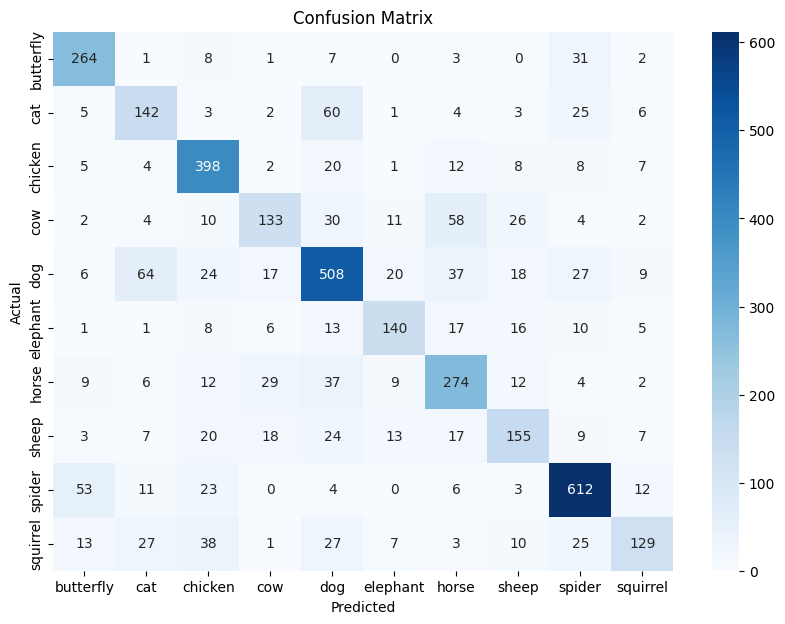

In [24]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"✅ Test Accuracy: {acc:.4f}")
print(f"🎯 F1 Score: {f1:.4f}")
print("\n📋 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 📊 Візуалізація результатів

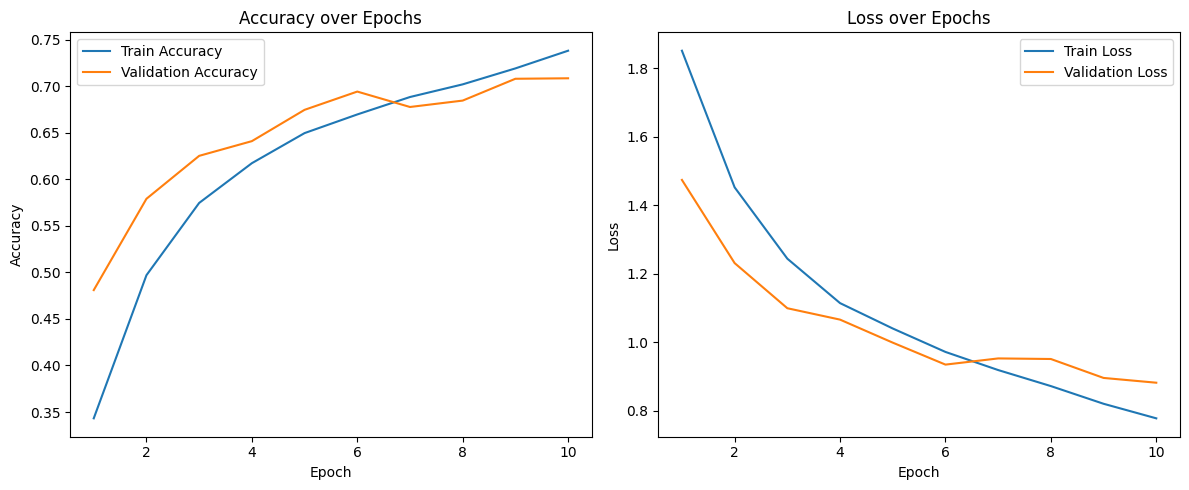

In [25]:
epochs = range(1, len(final_metrics["train_acc"]) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, final_metrics["train_acc"], label='Train Accuracy')
plt.plot(epochs, final_metrics["val_acc"], label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, final_metrics["train_loss"], label='Train Loss')
plt.plot(epochs, final_metrics["val_loss"], label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


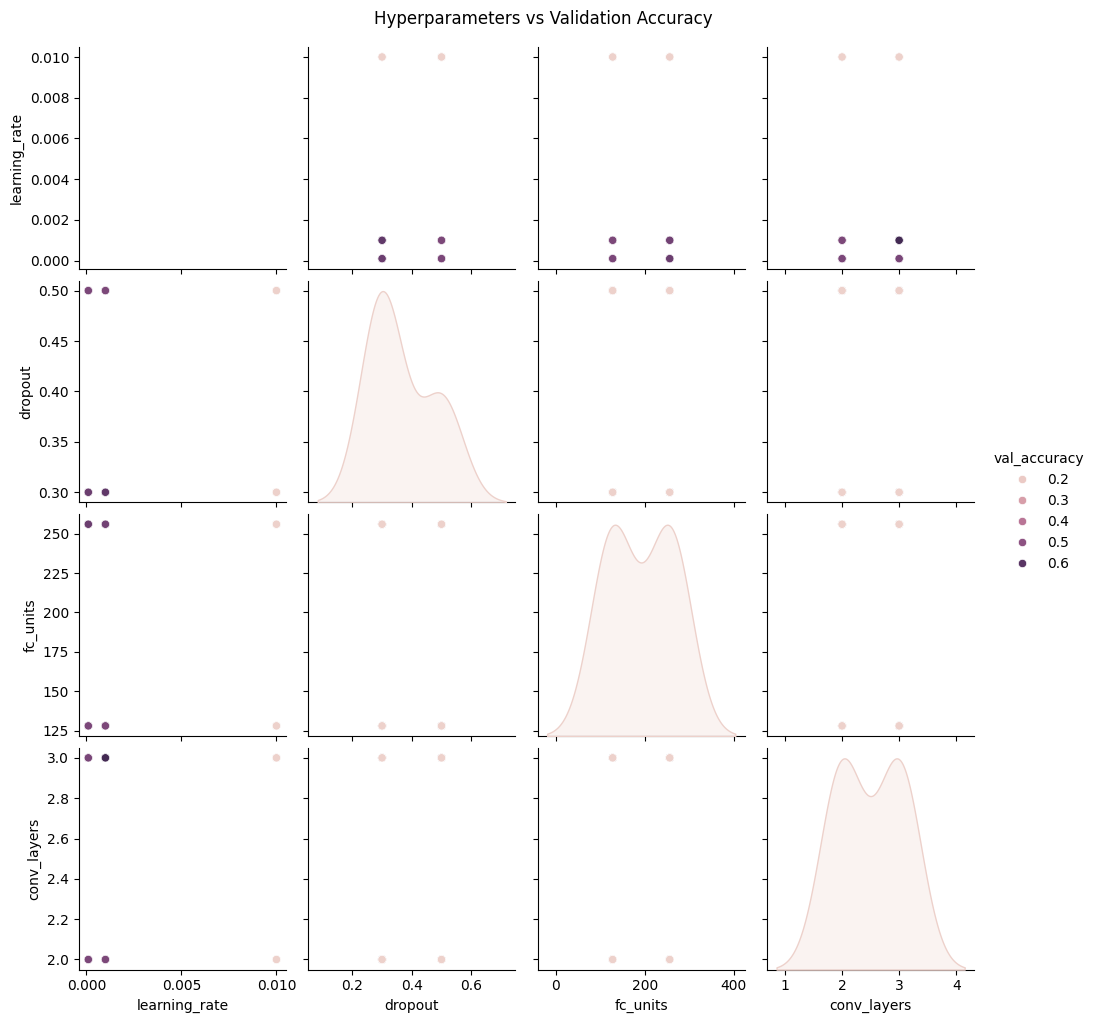

In [26]:
# Pairplot to visualize hyperparameter impact
import seaborn as sns

sns.pairplot(results_df, hue='val_accuracy', vars=["learning_rate", "dropout", "fc_units", "conv_layers"])
plt.suptitle("Hyperparameters vs Validation Accuracy", y=1.02)
plt.show()


In [27]:
# Save the final trained model to file
torch.save(model.state_dict(), "best_model.pth")
print("✅ Model saved as best_model.pth")


✅ Model saved as best_model.pth


## 📌 Висновки

🔍 Модель CNN з оптимізованими гіперпараметрами продемонструвала стабільну та хорошу продуктивність.

### 📊 Основні результати:
- ✅ **Test Accuracy:** 70.08%
- 🎯 **F1 Score (weighted avg):** 69.59%
- 📋 Високі показники точності по класах: `spider`, `chicken`, `butterfly`
- 🚧 Складність у класифікації: `cat`, `cow`, `squirrel` (низькі precision/recall)

### 📈 Поведінка моделі:
- Валідаційна точність стабільно зростала до 71%, не було overfitting
- Loss зменшувався рівномірно протягом 10 епох

### 🔧 Аналіз гіперпараметрів:
- Найкращий `learning_rate`: ~0.001
- Оптимальний `dropout`: 0.4–0.5
- Кількість conv шарів: 3, fc_units: 256
